<a href="https://colab.research.google.com/github/tozanni/bourbaki_deeplearning/blob/main/Intro_to_Pytorch_MLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción a Pytorch y MLP

## II. Perceptron multicapa

OJO: Este notebook se debe correr con backend de GPU.

### 1. Definición del DataSet


In [ ]:
import numpy as np 
import pandas as pd
import os
import torch
import torch.nn as nn

from skimage import io, transform

import torchvision
import torch.nn.functional as F
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader


Como veremos un poco después, este modelo puede crecer rápidamente de tamaño, por lo cual, nos veremos beneficiados de utilizar el GPU. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# https://pytorch.org/vision/stable/transforms.html

# ToPILImage(): Necesaria para poder aplicar transformaciones de torchvision
# Grayscale, reduce la cantidad de canales
# Resize: Reduce la dimension 
# ToTensor: Tensor PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)

transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Grayscale ( num_output_channels=1 ),
        transforms.Resize(260),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3451],std=[0.1683])
        ])

train_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/train/', transform=transform)
val_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/val/', transform=transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/test/', transform=transform)

dataloaders = {
    'train': DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2),
    'val': DataLoader(val_data, batch_size=64, shuffle=True, num_workers=2),
    'test': DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)
}


Ahora vamos a ejecutar el dataloader, imprimir la primera imagen. ¿Qué veremos? 


In [ ]:
#Ejercicio, probar con algunos de los siguientes flags

#Obtener la primera imagen con iterador
dataiter = iter(dataloaders['train'])
data, label = dataiter.next()

# El shape indica (num_rows, num_cols, num_channels)
# Color
# torch.Size([1, 260, 260, 3])

# Grayscale
# torch.Size([1, 260, 260])

In [ ]:
data, data.shape

(tensor([[[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           ...,
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515]]],
 
 
         [[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           ...,
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
           [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515]]],
 
 
         [[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
       

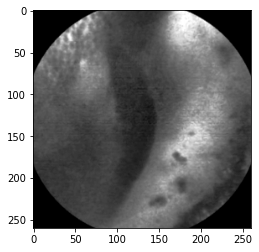

In [ ]:
plt.imshow(data[0][0], cmap='gray')

### 2. Perceptron multicapa

Adicional a la capa de entrada que es una función del tamaño de nuestras imágenes, agregaremos una capa intermedia de 512 unidades. 

La función de activación en ambos casos será la transformación lineal de los pesos mediante suma ponderada.


$$ y = xW^T + b $$


Ejercicio: Probar otras funciones de activación en la capa intermedia. Variar la arquitectura de la red. 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.input_fc = nn.Linear(260*260, 512)
        self.output = nn.Linear(512,1)
    
    def forward(self,x):
        # Aplanar la representacion
        x = x.view(-1,260*260)

        #Activacion sigmoidal en la capa intermedia
        h_1 = torch.sigmoid(self.input_fc(x))

        #Activacion lineal en la capa final
        y_pred = self.output(h_1)
        return y_pred

model = MLP()

# Correr en GPU si esta disponible
model.to(device)

print(model)

NameError: ignored

## 3. Funcion de perdida

In [ ]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

# TODO: Implementar pesos diferenciados por clase, ya que pos_weight=None

criterion = nn.BCEWithLogitsLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

### Ejecucion manual del paso de entrenamiento

Este proceso nos sirve para validar que el output de la red sea compatible con el input requerido por la funcion de perdida. 

Si estamos usando una perdida binaria vs. multi clase.  Si requiere el input en un cierto rango, etc. y la forma del tensor.


In [ ]:
dataiter = iter(dataloaders['train'])
data, label = dataiter.next()

data, label = data.to(device), label.to(device)


In [ ]:
model.train() # prep model for training
optimizer.zero_grad()
output = model(data)
output

tensor([[-0.5042],
        [-0.5185],
        [-0.6231],
        [-0.4682],
        [-0.5487],
        [-0.5485],
        [-0.5437],
        [-0.6476],
        [-0.4679],
        [-0.5150],
        [-0.5599],
        [-0.5550],
        [-0.6032],
        [-0.4939],
        [-0.4429],
        [-0.5932],
        [-0.5441],
        [-0.6043],
        [-0.4810],
        [-0.5777],
        [-0.4931],
        [-0.5547],
        [-0.6301],
        [-0.5188],
        [-0.5491],
        [-0.5605],
        [-0.5084],
        [-0.5415],
        [-0.4810],
        [-0.5626],
        [-0.5250],
        [-0.4989],
        [-0.5991],
        [-0.5136],
        [-0.5631],
        [-0.5633],
        [-0.5573],
        [-0.4706],
        [-0.5098],
        [-0.6166],
        [-0.5561],
        [-0.6084],
        [-0.5491],
        [-0.5212],
        [-0.5977],
        [-0.5242],
        [-0.6015],
        [-0.5948],
        [-0.5496],
        [-0.5341],
        [-0.5166],
        [-0.5367],
        [-0.

In [ ]:
# Para ver el resultado como probabilidad (de la clase 1)

torch.sigmoid(output)

tensor([[0.3766],
        [0.3732],
        [0.3491],
        [0.3851],
        [0.3662],
        [0.3662],
        [0.3673],
        [0.3435],
        [0.3851],
        [0.3740],
        [0.3636],
        [0.3647],
        [0.3536],
        [0.3790],
        [0.3911],
        [0.3559],
        [0.3672],
        [0.3534],
        [0.3820],
        [0.3595],
        [0.3792],
        [0.3648],
        [0.3475],
        [0.3731],
        [0.3661],
        [0.3634],
        [0.3756],
        [0.3678],
        [0.3820],
        [0.3630],
        [0.3717],
        [0.3778],
        [0.3546],
        [0.3744],
        [0.3628],
        [0.3628],
        [0.3642],
        [0.3845],
        [0.3752],
        [0.3505],
        [0.3645],
        [0.3524],
        [0.3661],
        [0.3726],
        [0.3549],
        [0.3719],
        [0.3540],
        [0.3555],
        [0.3660],
        [0.3696],
        [0.3737],
        [0.3690],
        [0.3641],
        [0.3700],
        [0.3680],
        [0

In [ ]:
# Para ver el resultado como etiqueta
torch.round(torch.sigmoid(output))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward>)

In [ ]:
label

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')

In [ ]:
label.unsqueeze(1)

tensor([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')

In [ ]:
#loss = criterion(output, label)

In [ ]:
loss = criterion(output, label.unsqueeze(1).float())
loss

tensor(0.8649, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

## 4. Training loop

Cosas importantes, invocar model.train() y model.eval() antes de entrar a fase de training y evaluacion del modelo. Eval() desactiva capas Dropout, BatchNorm, etc. que son propias del entrenamiento asi como el calculo de gradientes. 

Tiempo de entrenamiento: 3 min aprox (en GPU)

In [ ]:
n_epochs = 10
valid_loss_min = np.Inf  # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ## Loop de entrenamiento

    model.train() # prep model for training
    for data, label in dataloaders['train']:

        #Correr en GPU
        data, label = data.to(device), label.to(device)

        # borrar gradientes
        optimizer.zero_grad()
        # forward pass: calcular predicciones pasando los datos del batch al modelo
        output = model(data) 
        # calcular la perdida mediante la funcion seleccionada
        loss = criterion(output, label.unsqueeze(1).float())

        # backward pass: calcular el gradiente de la perdida respecto de los parametros
        loss.backward()
        # actualizar los parametros (ejecutar un paso de optimizacion)
        optimizer.step()
        # actualizar nuestra perdida de la epoca
        train_loss += loss.item() * data.size(0)
        
    ## Validacion

    model.eval()  # prep model for evaluation
    for data,label in dataloaders['val']:
        #GPU
        data, label = data.to(device), label.to(device)

        # forward pass: calcular predicciones
        output = model(data)

        # calcular la perdida
        loss = criterion(output, label.unsqueeze(1).float())
        
        # actualizar perdida de la iteracion
        valid_loss = loss.item() * data.size(0)
    
    train_loss = train_loss / len(dataloaders['train'].sampler)
    valid_loss = valid_loss / len(dataloaders['val'].sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Guardar modelo si la perdida de validacion disminuye
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'mlp_model_260x.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.556557 	Validation Loss: 0.020705
Validation loss decreased (inf --> 0.020705).  Saving model ...
Epoch: 2 	Training Loss: 0.519921 	Validation Loss: 0.029678
Epoch: 3 	Training Loss: 0.498568 	Validation Loss: 0.029083
Epoch: 4 	Training Loss: 0.482915 	Validation Loss: 0.025164
Epoch: 5 	Training Loss: 0.463523 	Validation Loss: 0.021809
Epoch: 6 	Training Loss: 0.450831 	Validation Loss: 0.022134
Epoch: 7 	Training Loss: 0.436102 	Validation Loss: 0.031505
Epoch: 8 	Training Loss: 0.417378 	Validation Loss: 0.025942
Epoch: 9 	Training Loss: 0.395228 	Validation Loss: 0.027850
Epoch: 10 	Training Loss: 0.379441 	Validation Loss: 0.024984


## 5. Evaluación en Test Set

In [ ]:
model.load_state_dict(torch.load('mlp_model_260x.pt'))

classes = list(range(0,2))

# Inicializacion
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation

for data, target in dataloaders['test']:
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target.unsqueeze(1).float())
    test_loss += loss.item()*data.size(0)

    # OJO: Convertir output de la red a predicciones
    pred = torch.round(torch.sigmoid(output))

    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # Calcular accuracy por clase
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(dataloaders['test'].sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))


Test Loss: 0.516190

Test Accuracy of     0: 26% (73/278)
Test Accuracy of     1: 92% (679/734)


In [ ]:
(73+679) / (278 + 734)

0.7430830039525692

In [ ]:
! cp "/content/mlp_model_260x.pt" "/content/drive/MyDrive/CarpetaImagenes/models/mlp_model_260x.pt"

## Referencias

Preparacion de dataset

https://colab.research.google.com/drive/1k8D9WilBf4NdTIEeZ0ye3E9AS91bsI3H#scrollTo=owx00y4Rx_kj

https://colab.research.google.com/drive/1J-mUZGJlnS73PwSPzx79TCCUuLHPITu2?usp=sharing


Dataset y dataloader

https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

Modelo simple

https://towardsdatascience.com/multilayer-perceptron-for-image-classification-5c1f25738935


Un tutorial interesante similar a este

[
https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=J3VsmcZU4O8I](https://)

